In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import relevant libraries
import pandas as pd
import numpy as np
import os
import random
# set project folder directory
DATA_DIR = "/content/drive/MyDrive/w266-finalproj/data"
subfolders = [ f.path for f in os.scandir('/content/drive/MyDrive') if f.is_dir() ]
print(subfolders)
#dir_list = os.listdir("/content/drive/MyDrive/W266 Project/w266-finalproj/data/02_intermediate")

['/content/drive/MyDrive/Accents', '/content/drive/MyDrive/Resume', '/content/drive/MyDrive/Colab Notebooks', '/content/drive/MyDrive/w266-finalproj', '/content/drive/MyDrive/301_Hidden_Layer_Pooled_BERT_3', '/content/drive/MyDrive/301_Hidden_Layer_Pooled_BERT']


In [ ]:
!pip install -q transformers
from transformers import BertTokenizer, TFBertModel

     |████████████████████████████████| 5.5 MB 8.4 MB/s 
     |████████████████████████████████| 7.6 MB 72.0 MB/s 
     |████████████████████████████████| 163 kB 85.2 MB/s 


In [ ]:
!pip install pydot --quiet
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [ ]:
# Reading in language CSV 
data = pd.read_csv(f"{DATA_DIR}/02_intermediate/language-processed-data.csv")
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data["genre"].replace({"country": "Country", "soul": "Soul", "jazz":"Jazz", 
                            "folk":"Folk", "pop":"Pop", "metal":"Metal", "rb":"R&B", 
                            "rock":"Rock", "rap":"Rap"}, inplace=True)
print(data.groupby(['genre']).size())

genre
Folk      3983
Jazz      4840
Metal     7833
Pop       8248
R&B       4335
Rap       9957
Rock     10022
Soul      4064
dtype: int64


In [ ]:
# Align the dataset to balance dataset
down_sample_to = 4000
npvalid_labels = ['Folk','Jazz','Metal','Pop','R&B','Rap','Rock','Soul']

In [ ]:
# training data processing
stopChars = [',','(',')','.','-','[',']','"']

# preprocessing the corpus by converting all letters to lowercase, 
# replacing blank lines with blank string and removing special characters
def preprocessText(text):
    processedText = text.lower()
    for char in stopChars:
        processedText = processedText.replace(char,'')
    return processedText

Basic EDA

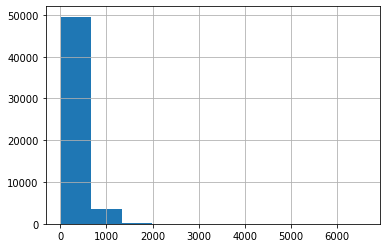

In [ ]:
#Histogram of word num
data.word_num.hist()

In [ ]:
def sample_data(genre, sample_size):
    data1 = data.copy()
    data1 = data1[data1['genre'] == genre].sample(sample_size)
    data1['lyrics'] = data1['lyrics'].astype(str)
    data1['lyrics']= data1['lyrics'].apply(preprocessText)
    return data1

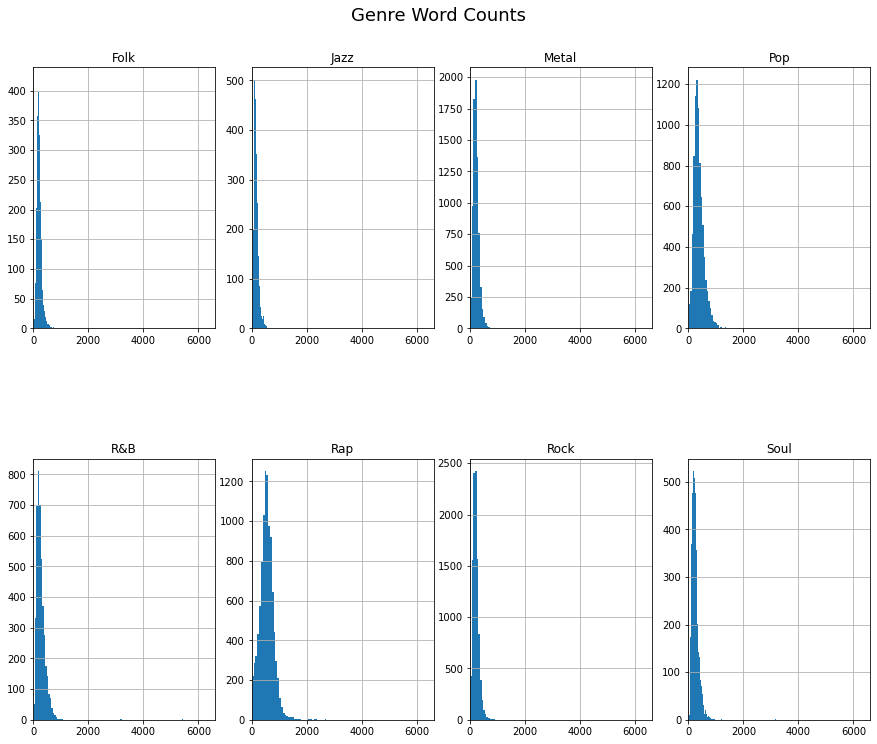

In [ ]:
# sample a subset of data
# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Genre Word Counts", fontsize=18, y=0.95)

max_val = data.word_num.max()

# loop through tickers and axes
for g, ax in zip(npvalid_labels, axs.ravel()):
    # filter df for ticker and plot on specified axes
    data_i = data[data.genre == g]
    data_i.word_num.hist(ax=ax,bins = 100)

    # chart formatting
    ax.set_title(g)
    ax.set_xlabel("")
    ax.set_xlim([0,max_val])
plt.show()


In [ ]:
def balance_dataset(dataset,label_name,n_i):
  balance_dataset = []
  unique_label = list(dataset[label_name].unique())
  for u in unique_label:
    df_i = dataset[dataset[label_name]==u]
    try:    df_i = df_i.sample(n=n_i, random_state=1)
    except: df_i = df_i.sample(n=n_i, random_state=1,replace=True)
    balance_dataset.append(df_i)
  balance_dataset=pd.concat(balance_dataset)
  balance_dataset = balance_dataset.sample(frac=1)
  return balance_dataset

data_balanced = balance_dataset(data,'genre',10000)

# Reading in language CSV 
print(data_balanced.groupby(['genre']).size())
print()


genre
Folk     10000
Jazz     10000
Metal    10000
Pop      10000
R&B      10000
Rap      10000
Rock     10000
Soul     10000
dtype: int64



In [ ]:
def make_plot(axs, history1, 
              history2, 
              y_lim_loss_lower=0.4, 
              y_lim_loss_upper=1.6,
              y_lim_accuracy_lower=0.4, 
              y_lim_accuracy_upper=0.9,
              model_1_name='model 1',
              model_2_name='model 2',
              
             ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0, 0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - ' + model_1_name)
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax3 = axs[1, 0]
    ax3.set_title('accuracy - ' + model_1_name)
    ax3.plot(history1.history['accuracy'])
    ax3.plot(history1.history['val_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)


    ax2 = axs[0, 1]
    ax2.set_title('loss - ' + model_2_name)
    ax2.plot(history2.history['loss'])
    ax2.plot(history2.history['val_loss'])
    ax2.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax4 = axs[1, 1]
    ax4.set_title('accuracy - ' + model_2_name)
    ax4.plot(history2.history['accuracy'])
    ax4.plot(history2.history['val_accuracy'])
    ax4.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)

In [ ]:
#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
label_dict = {}
for i,g in enumerate(['Folk','Jazz','Metal','Pop','R&B','Rap','Rock','Soul']):
  label_dict[g]=i
def read_songs(dataset,test_size=0.2):
  # download & load 20newsgroups dataset from sklearn's repos
  documents = dataset.lyrics  
  #labels = label_encoder.fit_transform(dataset.genre)
  labels = dataset['genre'].map(label_dict)

  labels_u = np.unique(labels)
  #labels = tf.keras.utils.to_categorical(labels, num_classes=len(labels_u))

  train_texts, test_texts,  train_labels, test_labels  = train_test_split(documents, labels, test_size=test_size)
  test_texts, valid_texts, test_labels, valid_labels = train_test_split(test_texts, test_labels, test_size=0.5)

  # split into training & testing a return data as well as label names
  return train_texts, test_texts, valid_texts, train_labels, test_labels, valid_labels, labels_u, dataset.genre
  
# call the function
train_texts, test_texts, valid_texts, train_labels, test_labels, valid_labels, unique_labels, target_names = read_songs(data_balanced)

In [ ]:
sum_all = 0
for t,ln in [['train',train_labels],['test', test_labels], ['valid',valid_labels]]:
  print(t)
  count_dict = {};sum_n = 0
  for i in unique_labels:
    n = len([e for e in ln if e == i]) 
    count_dict[i]=n; sum_n=sum_n+n
  pprint(count_dict, compact=True)
  sum_all = sum_all+sum_n
  print(sum_n)
print(sum_all)

train
{0: 7928, 1: 8065, 2: 7976, 3: 7984, 4: 7982, 5: 8071, 6: 7995, 7: 7999}
64000
test
{0: 1028, 1: 1003, 2: 1018, 3: 1001, 4: 997, 5: 965, 6: 1009, 7: 979}
8000
valid
{0: 1044, 1: 932, 2: 1006, 3: 1015, 4: 1021, 5: 964, 6: 996, 7: 1022}
8000
80000


In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor

max_length=100
train_encodings = bert_tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_texts.to_list(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings  = bert_tokenizer(test_texts.to_list(),  truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
#train_labels= train_labels.reshape(1,-1)
#test_labels = test_labels.reshape(1,-1)
#valid_labels= valid_labels.reshape(1,-1)
x = [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask]
y = train_labels
print(x[0].shape,x[1].shape,x[2].shape)
print(y.shape)

(64000, 100) (64000, 100) (64000, 100)
(64000,)


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                              

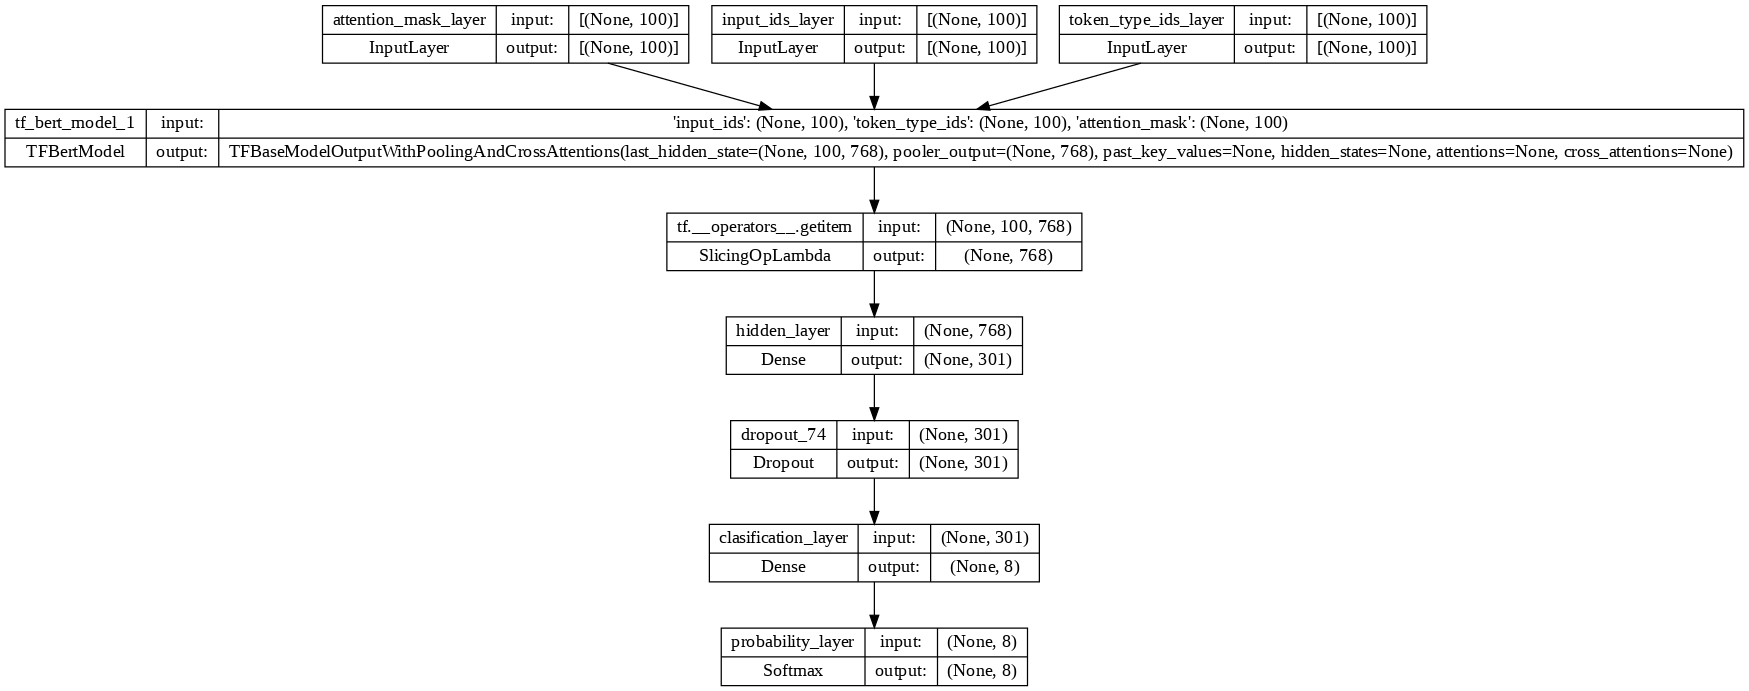

In [ ]:
def create_bert_multiclass_model(unique_labels,
                                checkpoint = model_checkpoint,
                                hidden_size = 301, 
                                dropout=0.3,
                                learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)                                             
    #bert_model.trainable = False
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)
    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    clasification_layer = tf.keras.layers.Dense(8,name='clasification_layer')(hidden)
    probability_layer = tf.keras.layers.Softmax(name='probability_layer')(clasification_layer)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=probability_layer)    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['accuracy'])
    ### END YOUR CODE
    return classification_model

pooled_bert_model = create_bert_multiclass_model(npvalid_labels,checkpoint = model_checkpoint)
pooled_bert_model.summary()
keras.utils.plot_model(pooled_bert_model, show_shapes=True, dpi=90)

In [ ]:
npvalid_labels = np.asarray(valid_labels)
pooled_bert_model_history = pooled_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  npvalid_labels), batch_size=16, epochs=10)  
model_name = "BERT_CLS_HL301_MW100.h5"
#pooled_bert_model.save('301_Hidden_Layer_Pooled_BERT')
CAT_DIR = "/content/drive/MyDrive/w266-finalproj/categorical_model"

pooled_bert_model.save(f"{CAT_DIR}/{model_name}",save_format='h5')

Epoch 1/10


4000/4000 [==============================] - 195s 46ms/step - loss: 1.2995 - accuracy: 0.5107 - val_loss: 0.9577 - val_accuracy: 0.6310
Epoch 2/10
4000/4000 [==============================] - 182s 46ms/step - loss: 0.8014 - accuracy: 0.6948 - val_loss: 0.8361 - val_accuracy: 0.6871
Epoch 3/10
4000/4000 [==============================] - 182s 46ms/step - loss: 0.5944 - accuracy: 0.7700 - val_loss: 0.7847 - val_accuracy: 0.7193
Epoch 4/10
4000/4000 [==============================] - 182s 46ms/step - loss: 0.4881 - accuracy: 0.8112 - val_loss: 0.7555 - val_accuracy: 0.7498
Epoch 5/10
4000/4000 [==============================] - 182s 46ms/step - loss: 0.4225 - accuracy: 0.8345 - val_loss: 0.7719 - val_accuracy: 0.7492
Epoch 6/10
4000/4000 [==============================] - 183s 46ms/step - loss: 0.3779 - accuracy: 0.8496 - val_loss: 0.8312 - val_accuracy: 0.7394
Epoch 7/10
4000/4000 [==============================] - 183s 46ms/step - loss: 0.3496 - accuracy: 0.8595 - val_loss: 0.9190 - val

In [ ]:
#pooled_bert_model.save('301_Hidden_Layer_Pooled_BERT')
#CAT_DIR = "/content/drive/MyDrive/w266-finalproj/categorical_model"
#pooled_bert_model.save(f"{CAT_DIR}/301_Hidden_Layer_Pooled_BERT")

#pooled_bert_model_history =  tf.keras.models.load_model(f"{CAT_DIR}/{model_name}")
pooled_bert_model.save(f"{CAT_DIR}/{model_name}",save_format='h5')
pooled_bert_model = create_bert_multiclass_model(npvalid_labels,checkpoint = model_checkpoint)
pooled_bert_model.load_weights(f"{CAT_DIR}/{model_name}") 

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


250/250 [==============================] - 9s 22ms/step - loss: 0.9355 - accuracy: 0.7523
Test loss: 0.9354733
Test accuracy: 0.75225
250/250 [==============================] - 7s 21ms/step


Text(159.0, 0.5, 'True')

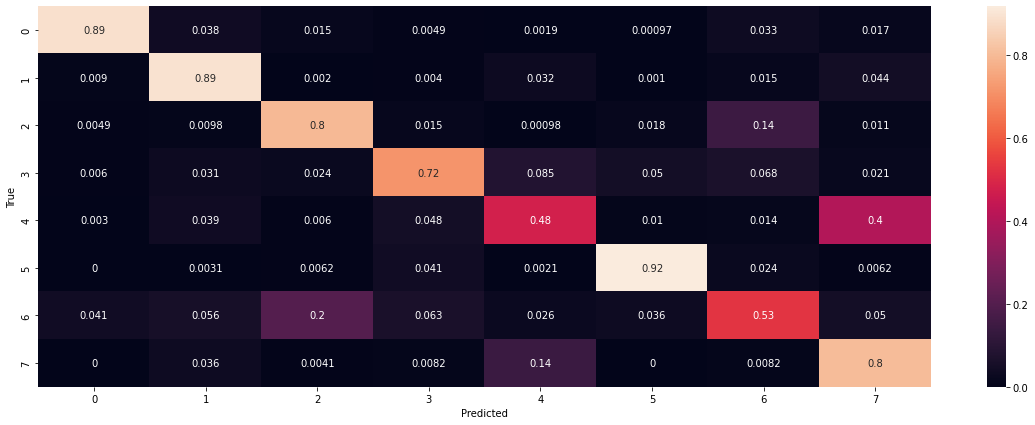

In [ ]:
score = pooled_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],test_labels) 
print('Test loss:', round(score[0],7)) 
print('Test accuracy:', round(score[1],7))

#run and capture all predictions from our test set using model.predict
predictions = pooled_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions = tf.argmax(predictions, axis=-1)

#print(classification_report(test_labels, predictions.numpy(), target_names=target_names))

#Confusion map
cm = tf.math.confusion_matrix(test_labels, predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=unique_labels,
    yticklabels=unique_labels)
plt.xlabel("Predicted")
plt.ylabel("True")